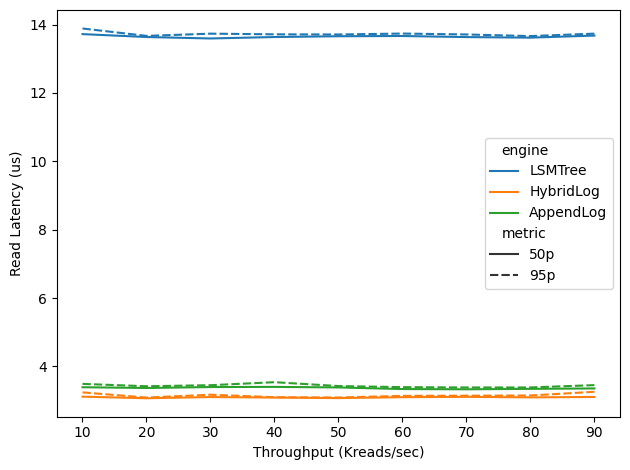

In [1]:
import sys
import pandas as pd
import seaborn as sns
from numpy import percentile
from utils import run
from distributions import Uniform, Zipfian
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathRemote
from pygav.data import lineplot, barplot, relplot
from pygav.utils import Timer
from utils import run


def measure_throughput_latency_reads(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    reads_per_secs = list(range(10_000, 100_000, 10_000))

    # first populate
    for k, v in zip(keys_set, vals_set):
        db[k] = v

    for reads_per_sec in reads_per_secs:
        latencies = []
        for i in range(seconds):
            with Timer() as latency:
                for _ in range(reads_per_sec):
                    _ = db[keys_set[next(distro)]]
            latency = float(latency)
            avg_latency = latency / reads_per_sec
            # if latency < 1:
            #     sleep(1 - latency)
            latencies.append(avg_latency)

        res.append({'metric': '50p', 'value': percentile(latencies, 50), 'reads_per_sec': reads_per_sec/1000})
        res.append({'metric': '95p', 'value': percentile(latencies, 95), 'reads_per_sec': reads_per_sec/1000})

    return res

df = run(
    [5], [5], [100_000], [0],
    [Uniform], [{'seed': [1]}],
    [LSMTree, HybridLog, AppendLog], [{
        'max_runs_per_level': [10],
        'density_factor': [10],
        'memtable_bytes_limit': [100_000],
        'remote': [None]
    },
    {
        'max_runs_per_level': [10],
        'ro_lag_interval': [10_000],
        'flush_interval': [10_000],
        'hash_index': ['dict'],
        'remote': [None]
    },
    {
        'max_runs_per_level': [10],
        'threshold': [100_000],
        'compaction': [False],
        'remote': [None]
    }],
    [measure_throughput_latency_reads], {}
)
data = df[['reads_per_sec', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['50p', '95p'])]
data['value'] = data['value'] * 1000000


lineplot(data=data, x='reads_per_sec', y='value', hue='engine', style='metric',
         filename='read-throughput.pdf', xlabel='Throughput (Kreads/sec)',
         ylabel='Read Latency (us)')

#5,5,100k,lookparams,10sec